In [737]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm


%matplotlib inline

In [738]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [739]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [740]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [741]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnectedLayer, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [781]:
class Encoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.bn1 = nn.BatchNorm2d(6) if batchnorm else None
        self.d1 = nn.Dropout2d() if dropout else None
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16) if batchnorm else None
        self.d2 = nn.Dropout2d() if dropout else None
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        if self.d1:
            x = self.d1(x)
        x = self.activation(x)
            
        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        if self.d2:
            x = self.d2(x)
        x = self.activation(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(16, 6, 3)
        self.bn1 = nn.BatchNorm2d(6) if batchnorm else None
        self.d1 = nn.Dropout2d() if dropout else None
        self.conv2 = nn.ConvTranspose2d(6, 1, 3)
        self.bn2 = nn.BatchNorm2d(1) if batchnorm else None
        self.d2 = nn.Dropout2d() if dropout else None
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        if self.d1:
            x = self.d1(x)
        x = self.activation(x)
            
        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        if self.d2:
            x = self.d2(x)
        x = self.activation(x)
        
        return x

In [782]:
class NetAeConv(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(NetAeConv, self).__init__()
        self.E = Encoder(batchnorm=batchnorm, dropout=dropout)
        self.D = Decoder(batchnorm=batchnorm, dropout=dropout)
        self._loss = F.mse_loss
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = self.E(x)
        out = self.D(x)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, output, target, **kwargs):
        return self._loss(output, target, **kwargs)

In [783]:
ae_models = {'bn': NetAeConv(batchnorm=True), 
             'drop': NetAeConv(batchnorm=False, dropout=True), 
             'plain': NetAeConv()}
train_log = {k: [] for k in ae_models}
test_log = {k: [] for k in ae_models}

In [784]:
def ae_train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (image, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(image) 
            loss = model.loss(output, image)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss(m(image), image)) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss(m(image), image)) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, None))
        print(line + losses)

In [785]:
def ae_test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for image, _ in loader:
            output = {k: m(image) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], image, reduction='sum').item() # sum up batch loss
    for k in models:
        test_loss[k] /= test_size
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], None))
    print(report)

In [786]:
def ae_run_models(models, n_epochs):
    for epoch in range(1, n_epochs+1):
        for model in models.values():
            model.train()
        ae_train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        ae_test(models, valid_loader, test_log)

In [787]:
ae_run_models(ae_models, 20)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 0.465037 drop: 0.207152 plain: 0.096432
Train Epoch: 1 [200/50000 (20%)]	Losses bn: 0.073438 drop: 0.120854 plain: 0.015163
Train Epoch: 1 [400/50000 (40%)]	Losses bn: 0.033658 drop: 0.113446 plain: 0.002969
Train Epoch: 1 [600/50000 (60%)]	Losses bn: 0.019477 drop: 0.103517 plain: 0.001603
Train Epoch: 1 [800/50000 (80%)]	Losses bn: 0.014736 drop: 0.089887 plain: 0.001141
Train Epoch: 1 [1000/50000 (100%)]	Losses bn: 0.010071 drop: 0.087374 plain: 0.000836
Test set:
bn: Loss: 8.0654
drop: Loss: 45.5982
plain: Loss: 0.6602

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.010392 drop: 0.087225 plain: 0.000797
Train Epoch: 2 [200/50000 (20%)]	Losses bn: 0.008273 drop: 0.087249 plain: 0.000579
Train Epoch: 2 [400/50000 (40%)]	Losses bn: 0.006760 drop: 0.105734 plain: 0.000455
Train Epoch: 2 [600/50000 (60%)]	Losses bn: 0.006435 drop: 0.068285 plain: 0.000345
Train Epoch: 2 [800/50000 (80%)]	Losses bn: 0.004619 drop: 0.082921 plain: 0.000408
Train Epoch:

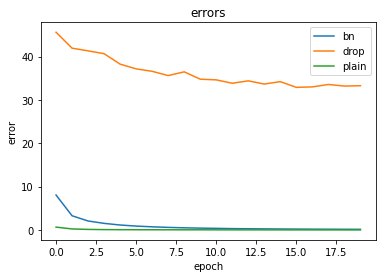

In [789]:
plot_graphs(test_log, 'loss')

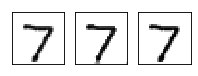

In [791]:
data, _ = next(iter(test_loader))
data = torch.unsqueeze(data[0], 0) # первая картинка из батча
#print ('data=',data)
images = []
for model in ae_models.values():
    image = model(data)
    #print ('image=',image)
    images.append(image)
to_plot = torch.cat(images, dim=0).data.numpy()
plot_mnist(to_plot, (1, 10))

In [792]:
# Классификатор
class NetClassifier(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(NetClassifier, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm)
        
        self.fc = FullyConnectedLayer([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [793]:
classif_models = {'bn': NetClassifier(True), 'drop': NetClassifier(False, True), 'plain': NetClassifier()}
train_log = {k: [] for k in classif_models}
test_log = {k: [] for k in classif_models}

In [794]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)            
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [795]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [796]:
def run_models(models, n_epochs):
    for epoch in range(1, n_epochs+1):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, test_log)

In [797]:
run_models(classif_models, 10)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.378395 drop: 2.314719 plain: 2.307720
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 0.642514 drop: 1.245082 plain: 1.334589
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 0.402607 drop: 0.575831 plain: 0.584106
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 0.248753 drop: 0.387689 plain: 0.365212
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.184462 drop: 0.345826 plain: 0.389944
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.069515 drop: 0.154836 plain: 0.157473
Test set:
bn: Loss: 0.1617	Accuracy: 9608.0/10000 (96%)
drop: Loss: 0.3466	Accuracy: 9017.0/10000 (90%)
plain: Loss: 0.3496	Accuracy: 8995.0/10000 (90%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.104856 drop: 0.336443 plain: 0.348639
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.126004 drop: 0.325438 plain: 0.329783
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.037840 drop: 0.176719 plain: 0.165642
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.143113 drop: 0.397183 plain: 0.37

In [757]:
###########################################################
# Оптимизация картинки под функцию потерь (классификатор) #
###########################################################

In [758]:
# перевод модели в режим inference [вывод предсказаний]
for model in classif_models.values():
    model.eval()

In [759]:
device = torch.device("cpu")

In [833]:
def optimize_image_by_class(model, class_number, num_steps=5000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))
    image = F.sigmoid(image)
    #print ('image before', image)
    #image = transforms.Normalize((0.1307,), (0.3081,))(image)
    #print ('image after', image)
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависеть от class_number
    loss_fn = F.nll_loss
    grads = []
    losses = []
    for i in tqdm.tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        loss = loss_fn(F.log_softmax(output, dim=1), torch.tensor([class_number]))
        loss.backward()
        grads.append(loss.grad)
        losses.append(loss)
        optim.step()
    
    # возвращаете картинку, grads, losses
    return F.sigmoid(image)*255, grads, losses

In [834]:
num_classes = 10
logs = [{k: [] for k in classif_models}] * num_classes
final_images = []
final_grads = []
for class_number in range(num_classes):
    class_images = {}
    class_grads = {}
    for model in classif_models.items():
        key, value = model
        image, grads, losses = optimize_image_by_class(value, class_number)
        class_images[key] = image
        class_grads[key] = grads
        for loss in losses:
            logs[class_number][key].append((loss, None))
    final_images.append(class_images)
    final_grads.append(class_grads)

100%|██████████| 5000/5000 [00:14<00:00, 336.49it/s]


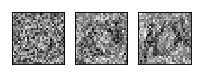

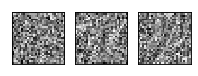

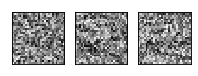

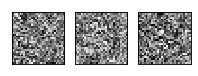

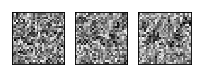

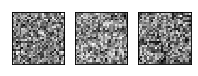

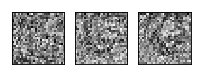

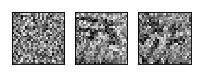

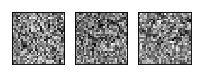

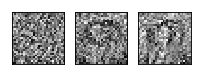

In [828]:
for class_images in final_images:
    images = []
    for k, image in class_images.items():
        image = image.view(-1, 1, 28, 28)
        images.append(image)
    to_plot = torch.cat(images, dim=0).data.numpy()
    plot_mnist(to_plot, (1, 10))

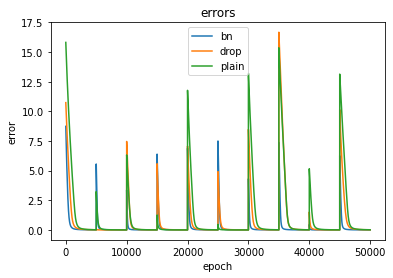

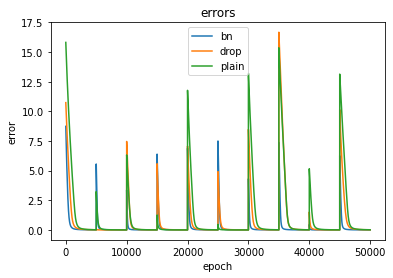

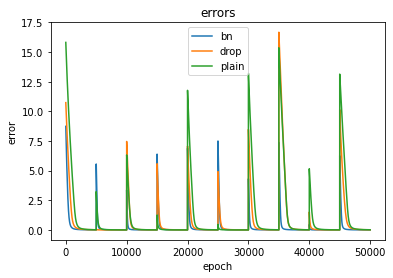

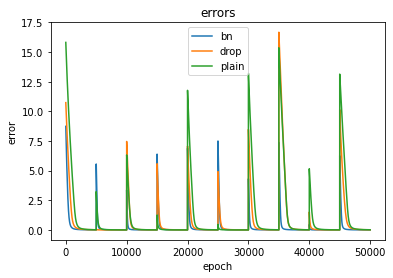

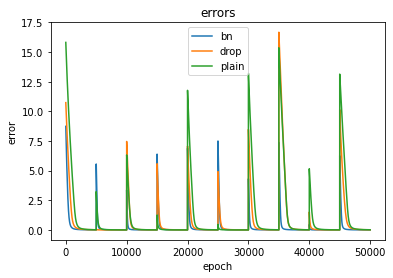

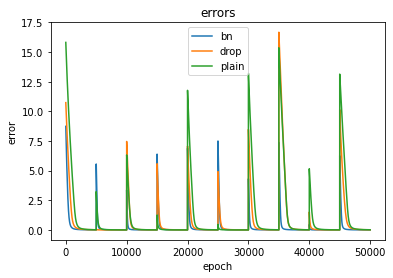

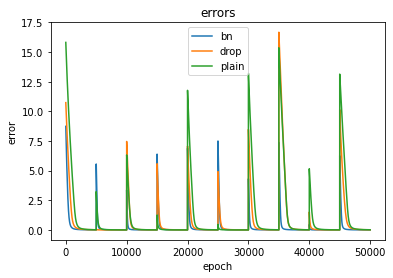

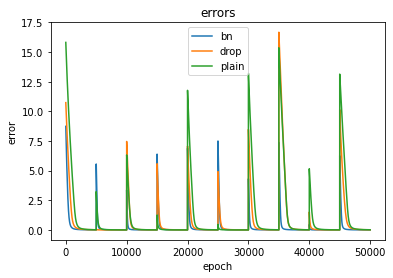

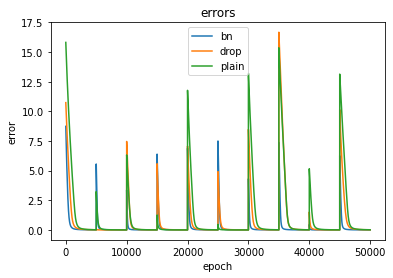

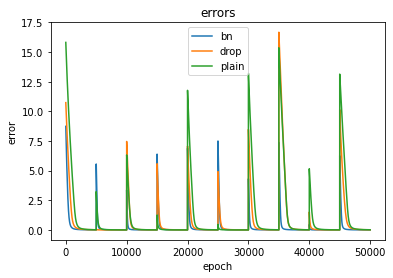

In [824]:
for class_number in range(num_classes):
    plot_graphs(logs[class_number], 'loss')

In [764]:
############################################################
# Оптимизация картинки под функцию потерь (автокодировщик) #
############################################################

In [765]:
for model in ae_models.values():
    model.eval()

In [830]:
def optimize_image_by_image(model, target_image, num_steps=10000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))
    image = F.sigmoid(image)
    #image = transforms.Normalize((0.1307,), (0.3081,))(image)
    image = image.to(device)
    image.requires_grad = True
    
    #print ('image=',image)
    #print ('target_image=',target_image)
    
    optim = torch.optim.Adam([image], lr=1e-4)
    
    loss_fn = F.mse_loss
    grads = []
    losses = []
    for i in tqdm.tqdm(range(num_steps)):
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        output = output.view(-1, 28, 28)
        output = F.sigmoid(output)
        #output = transforms.Normalize((0.1307,), (0.3081,))(output)
        loss = loss_fn(output, target_image)
        loss.backward()
        grads.append(loss.grad)
        losses.append(loss)
        optim.step()
    
    # возвращаете картинку, grads, losses
    return F.sigmoid(image)*255, grads, losses

In [831]:
ae_log = {k: [] for k in ae_models}
ae_final_images = {}
ae_final_grads = {}
data, _ = next(iter(test_loader))
data = torch.unsqueeze(data[0], 0) # первая картинка из батча
for model in ae_models.items():
    key, value = model
    image, grads, losses = optimize_image_by_image(value, data)
    ae_final_images[key] = image
    ae_final_grads[key] = grads
    for loss in losses:
        ae_log[key].append((loss, None))

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-830-c11500fe424b>:23: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target_image)
100%|██████████| 10000/10000 [00:26<00:00, 379.30it/s]


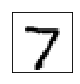

In [778]:
# Source image
to_plot = data.numpy()
plot_mnist(to_plot, (1, 1))

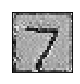

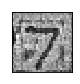

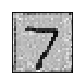

In [835]:
# Optimized images
for k, image in ae_final_images.items():
    to_plot = image.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 1))

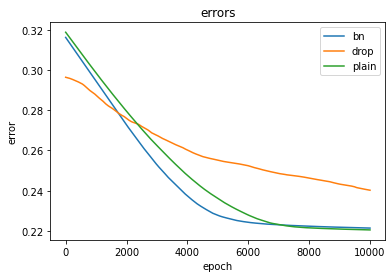

In [836]:
plot_graphs(ae_log, 'loss')